In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import muon as mu
# import anndata2ri
import logging
# import scvi
import os
import scipy
import scipy.io
import scib
# import rpy2.rinterface_lib.callbacks

import seaborn as sns
import matplotlib.pyplot as plt

# from rpy2.robjects import r
# from rpy2.robjects import pandas2ri

# rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# pandas2ri.activate()
# anndata2ri.activate()

# %load_ext rpy2.ipython

import warnings

warnings.filterwarnings("ignore")

In [45]:
atac = sc.read("/home/xcx/MYBenchmark-datas/1469/atac.h5ad", cache=True)
print(atac)
rna = sc.read("/home/xcx/MYBenchmark-datas/1469/raw_rna.h5ad", cache=True)
print(rna)

AnnData object with n_obs × n_vars = 1469 × 15857
    obs: 'barcode', 'cell_type', 'batch', 'modality'
    var: 'region_id', 'modality'
AnnData object with n_obs × n_vars = 1469 × 933
    obs: 'barcode', 'cell_type', 'batch', 'modality'
    var: 'gene_id', 'modality'


In [46]:
mdata = mu.MuData({"rna": rna, "atac": atac})
mdata.var_names_make_unique()
mdata

MuData object with n_obs × n_vars = 1469 × 16790
  var:	'modality'
  2 modalities
    rna:	1469 x 933
      obs:	'barcode', 'cell_type', 'batch', 'modality'
      var:	'gene_id', 'modality'
    atac:	1469 x 15857
      obs:	'barcode', 'cell_type', 'batch', 'modality'
      var:	'region_id', 'modality'

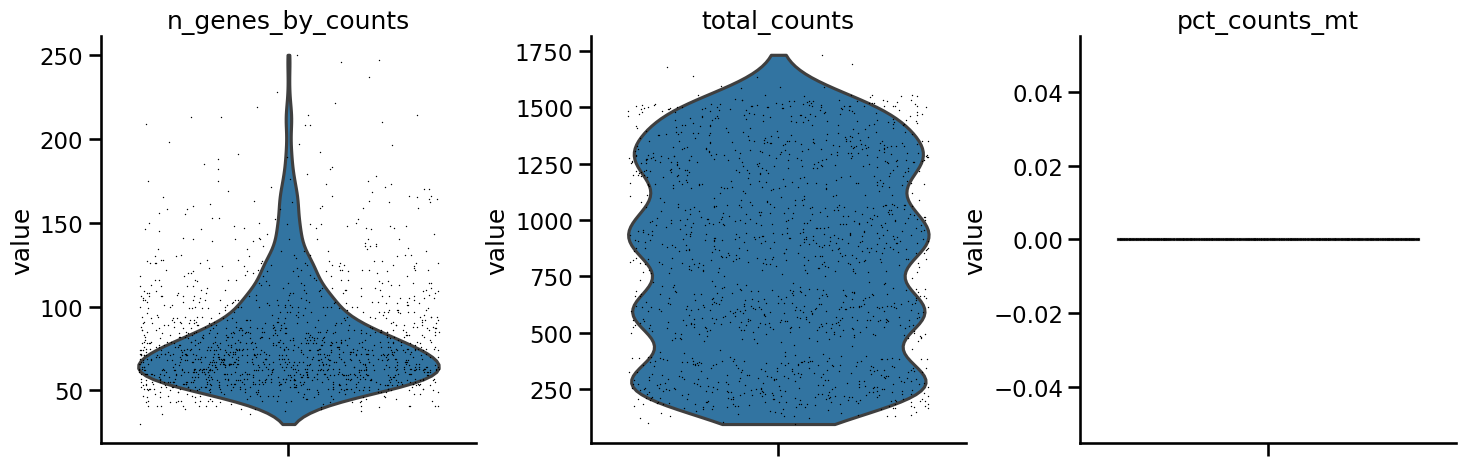

In [48]:
# QC
rna.var['mt'] = rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [50]:
# normalise
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)

# feature select
# sc.pp.highly_variable_genes(rna, n_top_genes=2500)
# sc.pl.highly_variable_genes(rna)

In [52]:
# save log-normalised in .raw
rna.raw = rna
# scale the log-normalised counts to zero mean and unit variance
sc.pp.scale(rna, max_value=10)

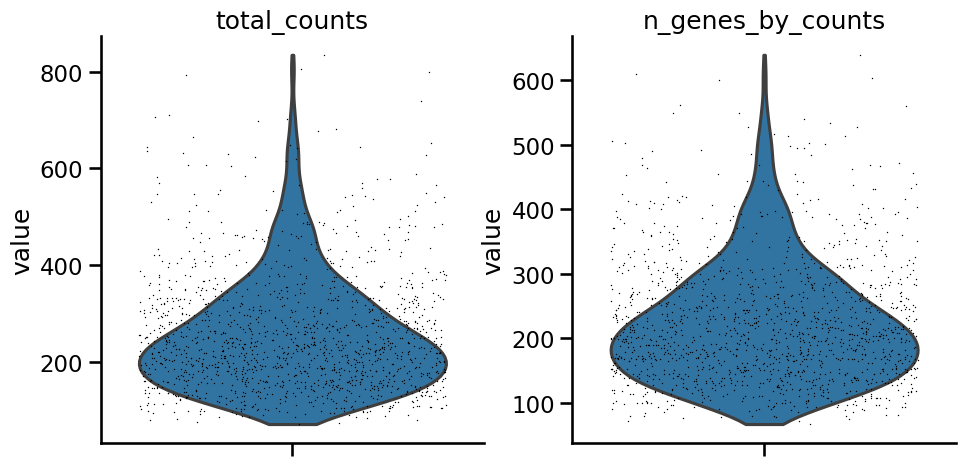

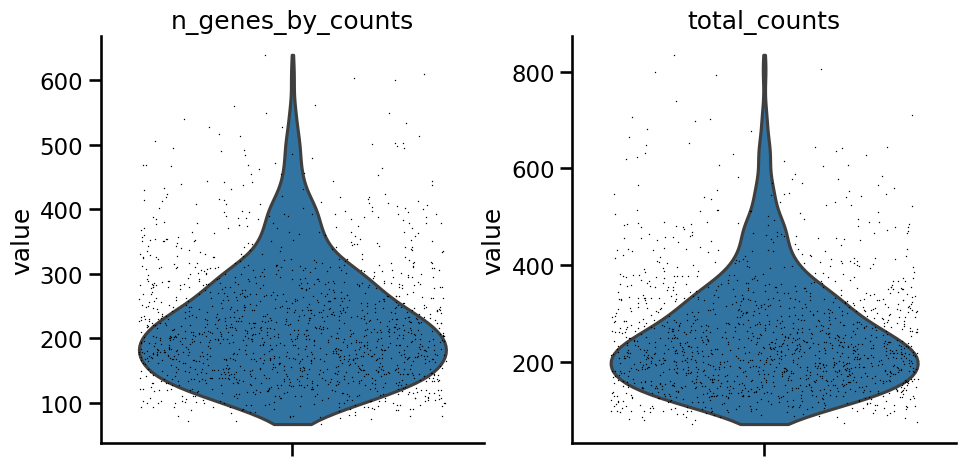

In [54]:
# QC
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)
sc.pl.violin(atac, ['total_counts', 'n_genes_by_counts'], jitter=0.4, multi_panel=True)
# for peaks
# mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 10)
# for cells
# mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 2000) & (x <= 15000))
# mu.pp.filter_obs(atac, 'total_counts', lambda x: (x >= 4000) & (x <= 40000))
sc.pl.violin(atac, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)

In [55]:
# normalisation
# Save original counts
from muon import atac as ac
atac.layers["counts"] = atac.X
ac.pp.tfidf(atac, scale_factor=1e4)
sc.pp.normalize_per_cell(atac, counts_per_cell_after=1e4)
sc.pp.log1p(atac)

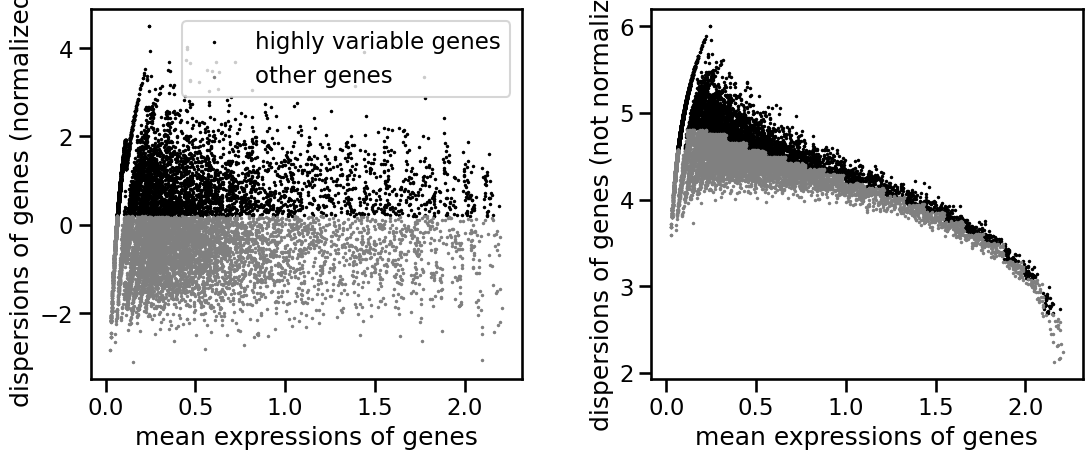

View of AnnData object with n_obs × n_vars = 1469 × 5001
    obs: 'barcode', 'cell_type', 'batch', 'modality', 'n_genes_by_counts', 'total_counts', 'n_counts'
    var: 'region_id', 'modality', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [56]:
# feature selection
sc.pp.highly_variable_genes(atac, n_top_genes=5000)
sc.pl.highly_variable_genes(atac)
atac=atac[:,atac.var.highly_variable]
atac

In [57]:
atac.raw = atac
atac

AnnData object with n_obs × n_vars = 1469 × 5001
    obs: 'barcode', 'cell_type', 'batch', 'modality', 'n_genes_by_counts', 'total_counts', 'n_counts'
    var: 'region_id', 'modality', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [58]:
# save data after preprossing
mdata = mu.MuData({"rna": rna, "atac": atac})
mdata.write("/home/xcx/MYBenchmark-codes/10-MOFA+/data/1469/1469.h5mu")

In [59]:
mdata = mu.read("/home/xcx/MYBenchmark-codes/10-MOFA+/data/1469/1469.h5mu")
mdata

MuData object with n_obs × n_vars = 1469 × 5934
  var:	'modality', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
  2 modalities
    rna:	1469 x 933
      obs:	'barcode', 'cell_type', 'batch', 'modality', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
      var:	'gene_id', 'modality', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
      uns:	'log1p'
    atac:	1469 x 5001
      obs:	'barcode', 'cell_type', 'batch', 'modality', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'region_id', 'modality', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg', 'log1p'
      layers:	'counts'

In [60]:
mu.pp.intersect_obs(mdata)
mdata.shape

(1469, 5934)

In [61]:
from sklearn.metrics import adjusted_rand_score as ari
ari(mdata.obs['rna:cell_type'], mdata.obs['atac:cell_type'])

1.0

<Axes: xlabel='rna:cell_type', ylabel='atac:cell_type'>

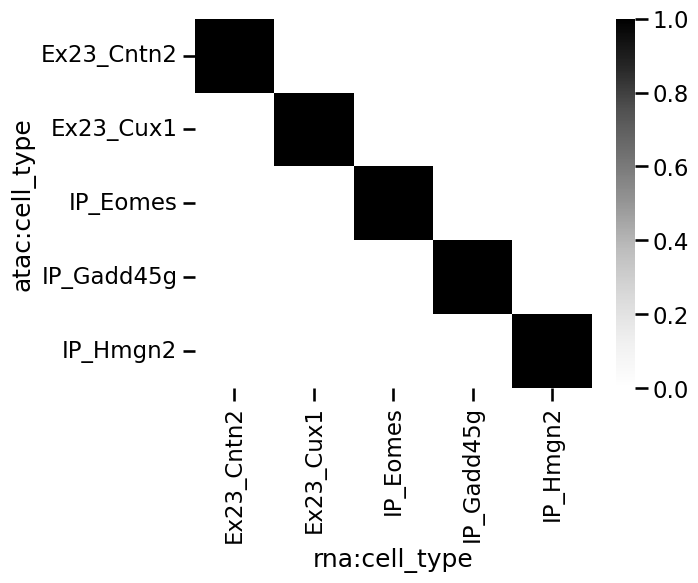

In [62]:
# Calculate total number of cells of respective ATAC celltypes
df_total = (
    mdata.obs.groupby("atac:cell_type").
        size().
        reset_index(name="n_total").
        set_index("atac:cell_type")
)

# Calculate number of cells for each pair of RNA-ATAC celltype annotation
df = (
    mdata.obs.groupby(["atac:cell_type", "rna:cell_type"]).
        size().
        reset_index(name="n").
        set_index("atac:cell_type").
        join(df_total).
        reset_index()
)

# Calculate a fraction of cells of each RNA celltype (n)
# for each ATAC celltype (/ n_total)
df_frac = df.assign(frac = lambda x: x.n / x.n_total)
df_wide = df_frac.set_index("atac:cell_type").pivot(columns="rna:cell_type", values="frac")
import seaborn as sns
sns.heatmap(df_wide, cmap="Greys")

In [63]:
mdata.obs["batch"] = mdata["rna"].obs["batch"].copy()
mdata.obs["cell_type"] = mdata["rna"].obs["cell_type"].copy()
mdata.obs

,rna:barcode,rna:cell_type,rna:batch,rna:modality,rna:n_genes_by_counts,rna:total_counts,rna:total_counts_mt,rna:pct_counts_mt,atac:barcode,atac:cell_type,atac:batch,atac:modality,atac:n_genes_by_counts,atac:total_counts,atac:n_counts,batch,cell_type
cell-1,GGCAATGGCCCT,IP_Eomes,1.0,scRNA-seq,150,223.0,0.0,0.0,GGCAATGGCCCT,IP_Eomes,1.0,scATAC-seq,527,665.0,4518.742676,1.0,IP_Eomes
cell-2,CTACACCACACC,IP_Eomes,1.0,scRNA-seq,185,294.0,0.0,0.0,CTACACCACACC,IP_Eomes,1.0,scATAC-seq,424,511.0,3640.951660,1.0,IP_Eomes
cell-3,ACCTGGCCTGCC,IP_Eomes,1.0,scRNA-seq,208,344.0,0.0,0.0,ACCTGGCCTGCC,IP_Eomes,1.0,scATAC-seq,423,513.0,3760.297363,1.0,IP_Eomes
cell-4,CCGGTCCCTACT,Ex23_Cux1,1.0,scRNA-seq,165,251.0,0.0,0.0,CCGGTCCCTACT,Ex23_Cux1,1.0,scATAC-seq,494,624.0,4007.744873,1.0,Ex23_Cux1
cell-5,TGATGATCATGT,Ex23_Cux1,1.0,scRNA-seq,219,385.0,0.0,0.0,TGATGATCATGT,Ex23_Cux1,1.0,scATAC-seq,562,739.0,4377.163086,1.0,Ex23_Cux1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell-1465,GCCCGGCGCTCA,IP_Hmgn2,1.0,scRNA-seq,62,1534.0,0.0,0.0,GCCCGGCGCTCA,IP_Hmgn2,1.0,scATAC-seq,123,133.0,1531.469238,1.0,IP_Hmgn2
cell-1466,ATCGCCCCAGGT,Ex23_Cntn2,1.0,scRNA-seq,64,1532.0,0.0,0.0,ATCGCCCCAGGT,Ex23_Cntn2,1.0,scATAC-seq,78,81.0,1101.788208,1.0,Ex23_Cntn2
cell-1467,CATGTTTGCAAA,Ex23_Cntn2,1.0,scRNA-seq,57,1528.0,0.0,0.0,CATGTTTGCAAA,Ex23_Cntn2,1.0,scATAC-seq,81,84.0,1074.273804,1.0,Ex23_Cntn2
cell-1468,TTAGACCCGCTA,IP_Hmgn2,1.0,scRNA-seq,43,1514.0,0.0,0.0,TTAGACCCGCTA,IP_Hmgn2,1.0,scATAC-seq,90,92.0,1294.213135,1.0,IP_Hmgn2


In [64]:
import datetime
starttime = datetime.datetime.now()

mu.tl.mofa(mdata, gpu_mode=True, outfile="/home/xcx/results/1469/10-MOFA+/snare_rna_atac.hdf5")

#long running
endtime = datetime.datetime.now()
print((endtime-starttime).seconds)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='rna' group='group1' with N=1469 samples and D=933 features...
Loaded view='atac' group='group1' with N=1469 samples and D=5001 features...


Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: Tr

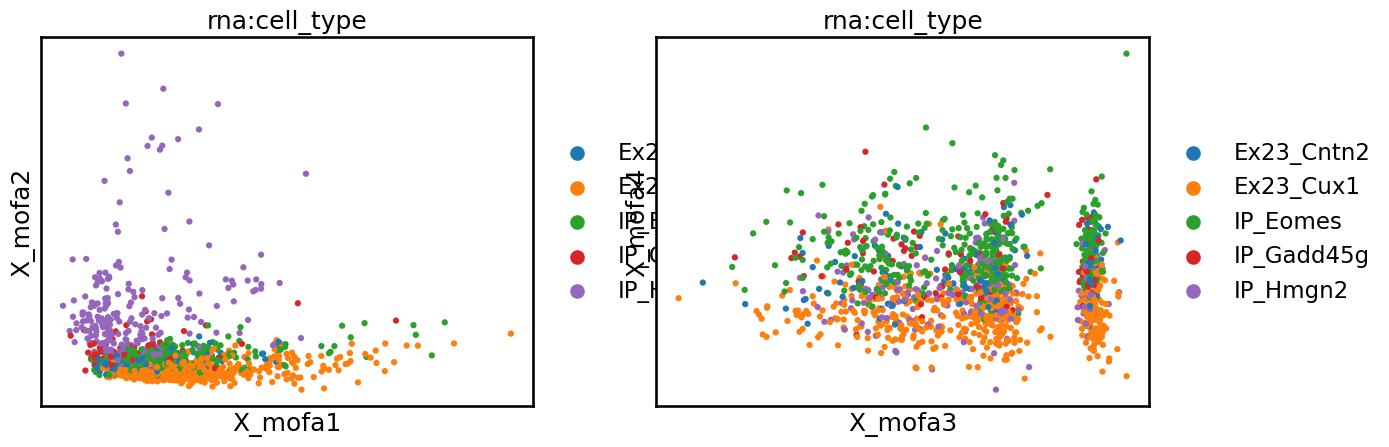

In [66]:
mu.pl.mofa(mdata, color="rna:cell_type", components=["1,2", "3,4"])
# 'rna:celltype' is a column in mdata.obs
# derived from the 'celltype' column of mdata['rna'].obs

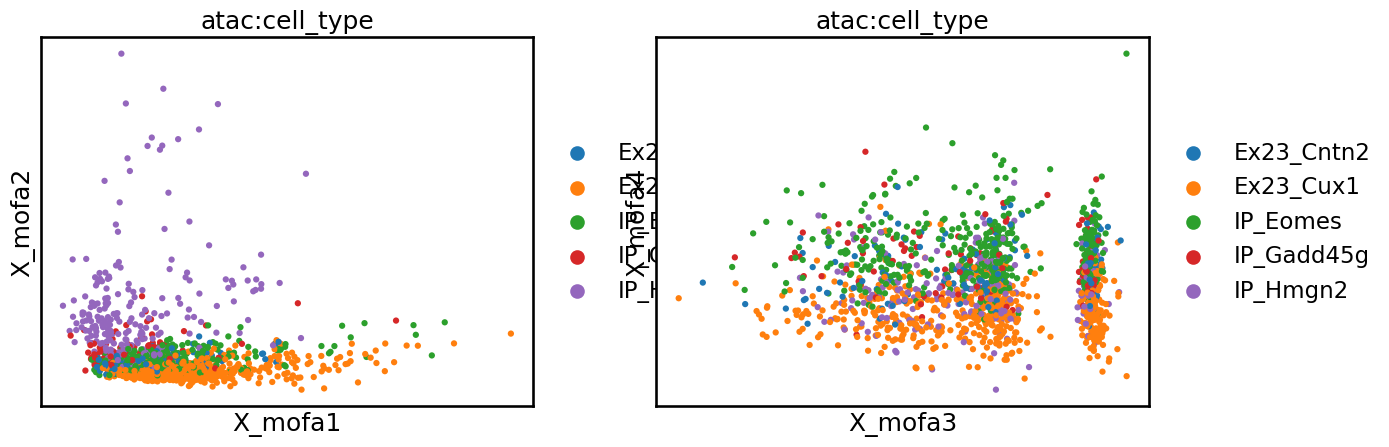

In [67]:
mu.pl.mofa(mdata, color="atac:cell_type", components=["1,2", "3,4"])
# 'atac:celltype' is a column in mdata.obs
# derived from the 'celltype' column of mdata['atac'].obs

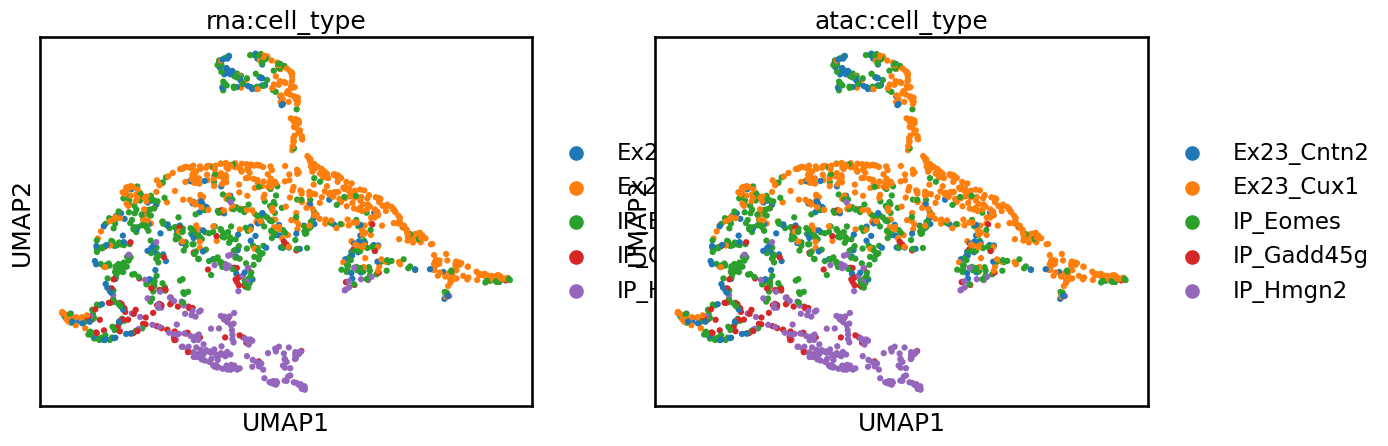

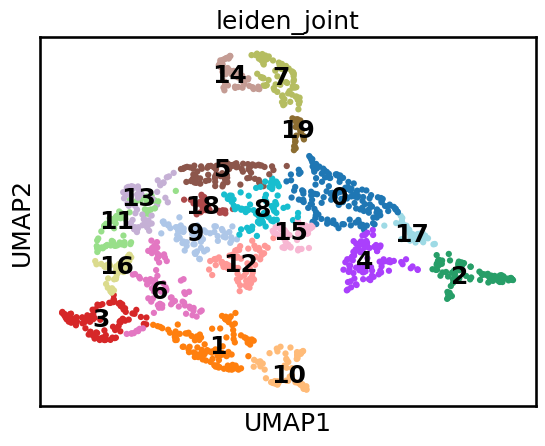

In [68]:
sc.pp.neighbors(mdata, use_rep="X_mofa")
sc.tl.umap(mdata)
sc.tl.umap(mdata, min_dist=.2, spread=1., random_state=10)
sc.pl.umap(mdata, color=["rna:cell_type", "atac:cell_type"])
sc.tl.leiden(mdata, key_added='leiden_joint')
sc.pl.umap(mdata, color="leiden_joint", legend_loc='on data')

In [72]:
scib_anndata = sc.AnnData(mdata.obsm["X_mofa"]).copy()
scib_anndata.obs = mdata.obs.copy()
scib_anndata.obsp["connectivities"] = mdata.obsp["connectivities"].copy()
scib_anndata.obsm["X_mofa"] = mdata.obsm["X_mofa"].copy()

In [73]:
metrics_mofa = scib.metrics.metrics(
    scib_anndata,
    scib_anndata,
    batch_key="rna:batch",
    label_key="rna:cell_type",
    embed="X_mofa",
    ari_=True,
    nmi_=True,
    silhouette_=True,
    graph_conn_=True,
    isolated_labels_asw_=True,
)
metrics_mofa

NMI...
ARI...
Silhouette score...
Isolated labels ASW...
Graph connectivity...


,0
NMI_cluster/label,0.270392
ARI_cluster/label,0.140658
ASW_label,0.464012
ASW_label/batch,NaN
PCR_batch,NaN
cell_cycle_conservation,NaN
isolated_label_F1,NaN
isolated_label_silhouette,0.478209
graph_conn,0.841345
kBET,NaN


In [69]:
print(mdata.obsm["X_mofa"])
print(type(mdata.obsm["X_mofa"]))
print(mdata.obsm["X_mofa"].shape)

df = pd.DataFrame(data=mdata.obsm["X_mofa"])
df.to_csv(os.path.join("/home/xcx/results/1469/10-MOFA+/z_both.csv"), index=False)

[[ 6.81520405e+00  3.58599607e-02 -1.97155412e-01 ... -9.47440653e-07
  -5.28292333e-07 -1.60582066e-06]
 [ 6.40827440e+00  1.05534428e+00  3.42163538e-01 ... -1.59985186e-06
  -1.39824872e-07  3.87820716e-08]
 [ 7.14365160e+00  1.67327014e+00 -6.48085051e-02 ... -8.09211946e-07
  -3.89054782e-07 -4.32954763e-07]
 ...
 [-1.65410931e+00 -1.83887641e-01  2.60061763e-01 ...  1.59593500e-07
   1.61133915e-07 -3.47432776e-10]
 [-2.26925798e+00  6.93514590e-01  2.45544752e-01 ...  1.90997757e-08
  -1.63773667e-07  1.60618576e-07]
 [-1.35097569e+00  3.27682715e-01 -4.14311191e-01 ...  4.97096888e-08
   1.28998486e-07  3.53902909e-07]]
<class 'numpy.ndarray'>
(1469, 10)


In [70]:
sc.pp.neighbors(mdata, use_rep="X_mofa")
sc.tl.umap(mdata)
mdata.obsm["X_umap_mofa"] = mdata.obsm["X_umap"].copy()

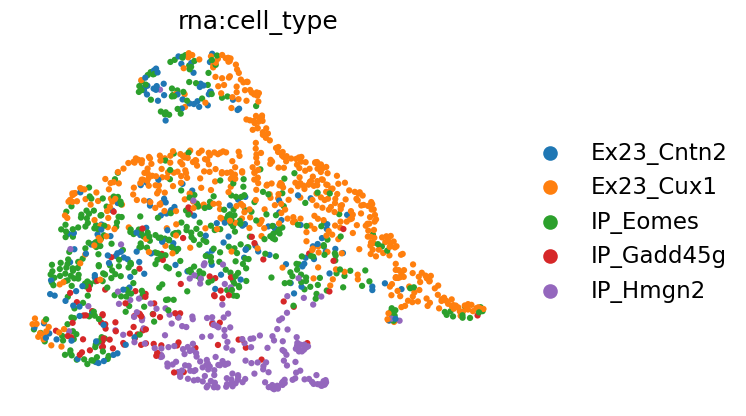

In [71]:
mu.pl.embedding(
    mdata, color=["rna:cell_type"], ncols=1, basis="umap_mofa", frameon=False
)